# Project Purpose: Bearing Fault Classification Using Vibration Data

## **Objective**
The primary objective of this project is to develop a machine learning model that can accurately classify different types of bearing faults in rotating machinery based on vibration acceleration data. By analyzing the vibration patterns, the model aims to identify faults such as inner race faults, outer race faults, facilitating predictive maintenance and minimizing equipment downtime.

## **Background**
Rotating machinery is integral to various industrial applications, including manufacturing, energy production, and transportation. Bearings are critical components that ensure the smooth operation of these machines. However, bearings are susceptible to faults that can lead to equipment failure, operational disruptions, and increased maintenance costs. Early detection of these faults is essential for effective maintenance strategies.

Vibration analysis is a widely used technique for monitoring the health of rotating machinery. By capturing and analyzing vibration signals, it is possible to detect anomalies that indicate the presence of faults. This project leverages a comprehensive dataset containing vibration and acoustic measurements under various fault conditions and operating parameters to build a reliable classification model.

## **Goals**
- **Data Preprocessing**: Clean and prepare the vibration data for analysis, including handling missing values and normalizing the data.
- **Exploratory Data Analysis (EDA)**: Gain insights into the data through visualization and statistical analysis to understand the characteristics of different fault types.
- **Feature Extraction**: Derive meaningful features from the time and frequency domains of the vibration signals to enhance model performance.
- **Model Development**: Implement and train machine learning algorithms to classify bearing faults based on the extracted features.
- **Model Evaluation**: Assess the performance of the classification model using appropriate metrics and validate its effectiveness in real-world scenarios.
- **Visualization & Reporting**: Present the findings through clear visualizations and comprehensive documentation to demonstrate the project's outcomes.

## **Significance**
Accurate classification of bearing faults enables timely maintenance interventions, reducing the risk of unexpected machine failures and extending the lifespan of industrial equipment. This project not only provides practical experience in data science and machine learning but also contributes to the field of predictive maintenance by exploring effective strategies for fault detection in rotating machinery.

## **Scope**
While the dataset includes various types of faults and operating conditions, this project will focus on:
- **Fault Types**: Inner race faults, outer race faults, and ball faults.
- **Operating Conditions**: Constant rotating speed (3010 RPM) under different loads (0 Nm, 2 Nm, 4 Nm).
- **Data Types**: Vibration (acceleration) data in both x and y-directions.

## **Tools & Technologies**
- **Programming Language**: Python
- **Libraries**:
  - Data Handling: `pandas`, `NumPy`
  - Visualization: `matplotlib`, `seaborn`
  - Signal Processing: `SciPy`, `librosa`
  - Machine Learning: `scikit-learn`
- **Development Environment**: Jupyter Notebook

## **Expected Outcomes**
- A trained machine learning model capable of accurately classifying bearing faults based on vibration data.
- Comprehensive analysis and visualization of the vibration signals associated with different fault types.
- Insightful documentation detailing the methodology, results, and potential areas for future improvement.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, fftfreq
import os
import glob

from scipy.stats import skew, kurtosis


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC

## Explanatory Data Analysis

In [2]:
def load_and_analyze_vibration(file_path, condition_name):
    # Load the data
    df = pd.read_csv(file_path)
    
    # 1. Time Series Plot for all directions
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    # Plot Housing A
    plt.plot(df['Time Stamp'][:1000], df['x_direction_housing_A'][:1000], 
             label='X direction - Housing A', alpha=0.7)
    plt.plot(df['Time Stamp'][:1000], df['y_direction_housing_A'][:1000], 
             label='Y direction - Housing A', alpha=0.7)
    plt.title(f'Housing A Vibrations - {condition_name}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude (g)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    # Plot Housing B
    plt.plot(df['Time Stamp'][:1000], df['x_direction_housing_B'][:1000], 
             label='X direction - Housing B', alpha=0.7)
    plt.plot(df['Time Stamp'][:1000], df['y_direction_housing_B'][:1000], 
             label='Y direction - Housing B', alpha=0.7)
    plt.title('Housing B Vibrations')
    plt.xlabel('Time')
    plt.ylabel('Amplitude (g)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. FFT Analysis for each direction
    sampling_rate = 25600
    vibration_columns = [
        'x_direction_housing_A',
        'y_direction_housing_A',
        'x_direction_housing_B',
        'y_direction_housing_B'
    ]
    
    plt.figure(figsize=(15, 10))
    
    for idx, column in enumerate(vibration_columns, 1):
        plt.subplot(2, 2, idx)
        signal = df[column].values
        fft_result = fft(signal)
        freq = fftfreq(len(signal), 1/sampling_rate)
        
        # Plot only positive frequencies up to 5000 Hz
        pos_freq_mask = (freq >= 0) & (freq <= 5000)
        plt.plot(freq[pos_freq_mask], np.abs(fft_result)[pos_freq_mask])
        plt.title(f'FFT Analysis: {column}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()

    # 3. Statistical Analysis
    print(f"\nStatistical Summary for {condition_name}:")
    print(df[vibration_columns].describe())

    # 4. Correlation Heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[vibration_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                center=0, vmin=-1, vmax=1, fmt='.2f')
    plt.title(f'Correlation Heatmap: {condition_name}')
    plt.show()

    # 5. Box Plot for Amplitude Distribution
    plt.figure(figsize=(12, 6))
    df[vibration_columns].boxplot()
    plt.title(f'Amplitude Distribution: {condition_name}')
    plt.xticks(rotation=45)
    plt.ylabel('Amplitude (g)')
    plt.grid(True)
    plt.show()

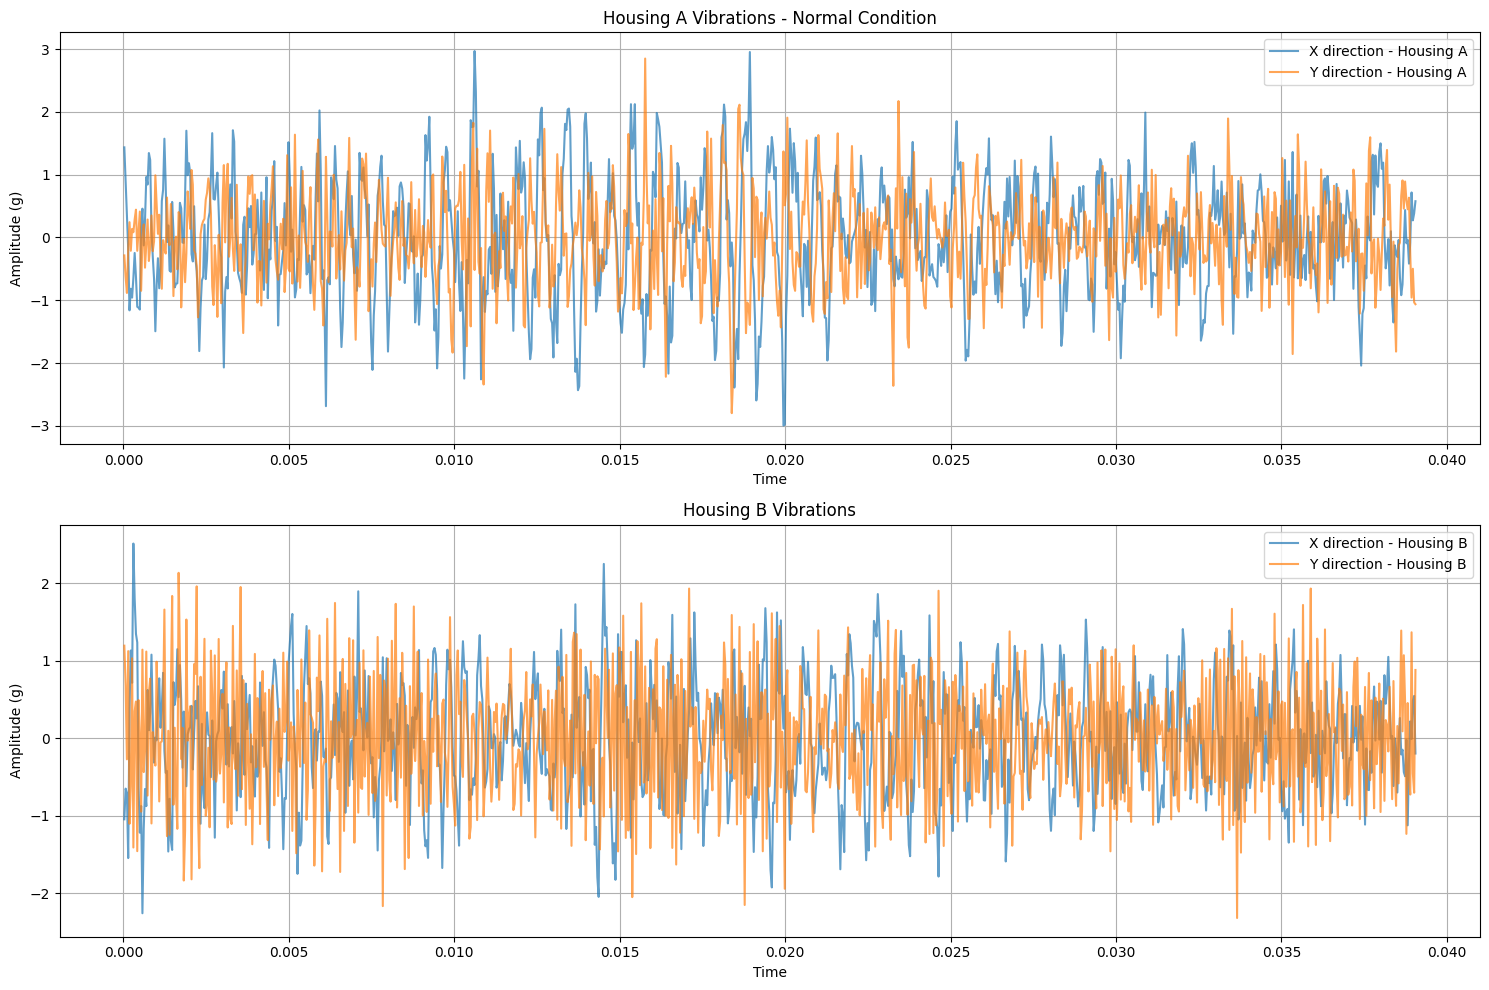

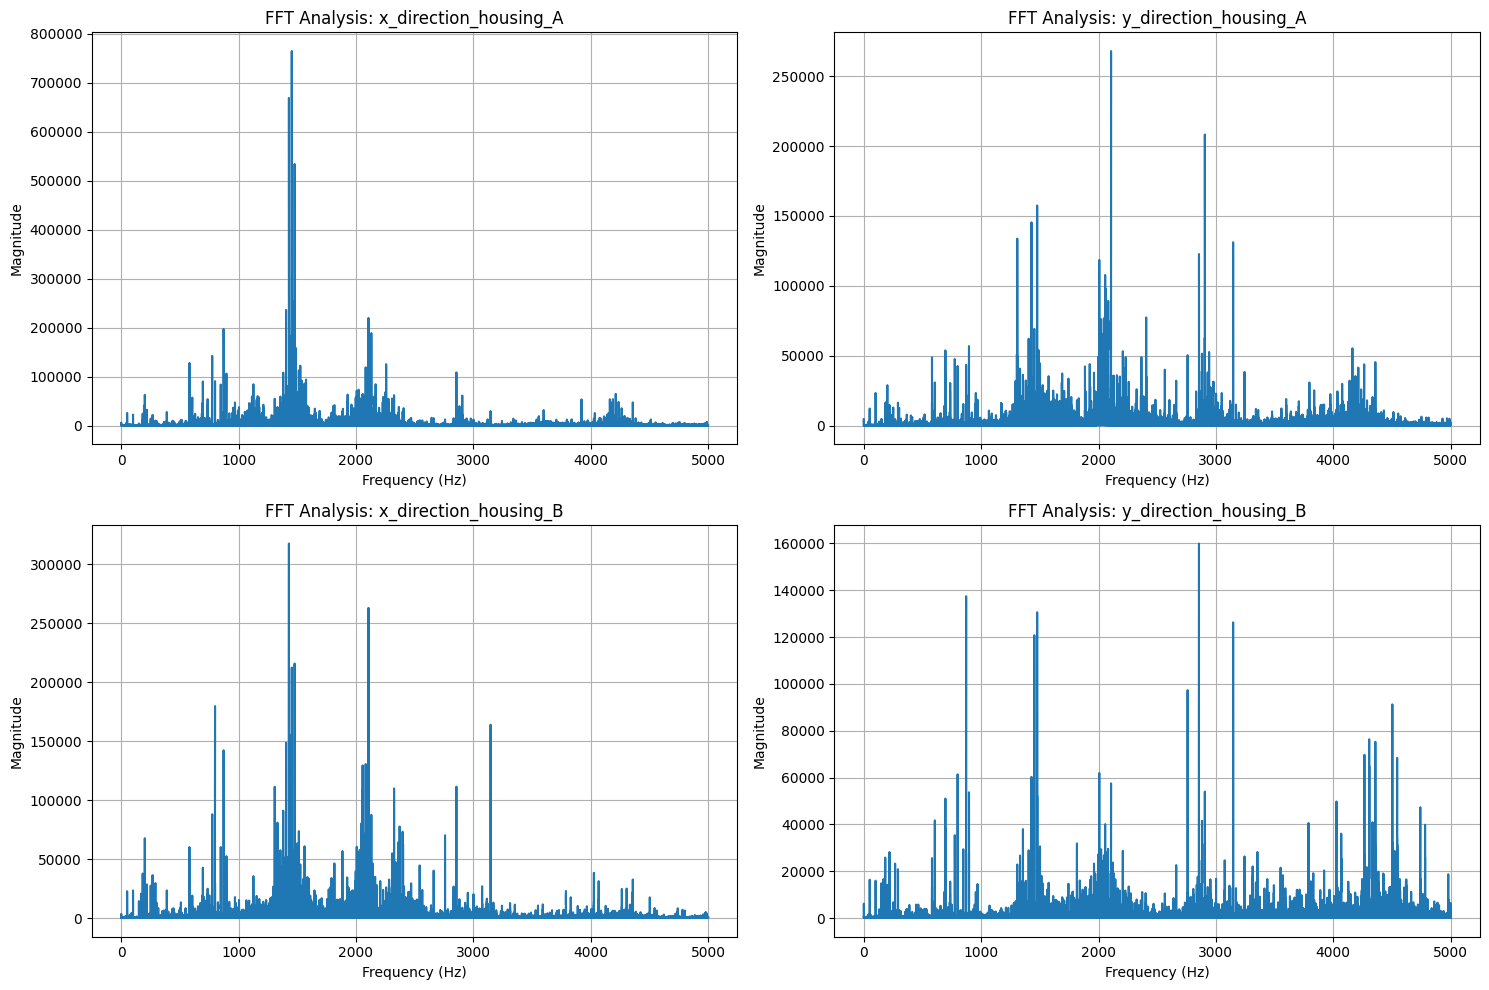


Statistical Summary for Normal Condition:
       x_direction_housing_A  y_direction_housing_A  x_direction_housing_B  \
count           7.680000e+06           7.680000e+06           7.680000e+06   
mean            3.243287e-05          -6.983252e-05          -7.809284e-05   
std             1.003506e+00           7.176867e-01           7.135996e-01   
min            -5.289118e+00          -4.082939e+00          -4.130716e+00   
25%            -6.697034e-01          -4.809930e-01          -4.813542e-01   
50%            -2.524008e-03          -1.195905e-03          -1.197101e-04   
75%             6.683813e-01           4.794383e-01           4.806360e-01   
max             6.203771e+00           4.211738e+00           3.498527e+00   

       y_direction_housing_B  
count           7.680000e+06  
mean           -6.336816e-05  
std             7.206216e-01  
min            -3.619702e+00  
25%            -5.181445e-01  
50%            -1.198299e-03  
75%             5.168264e-01  
max   

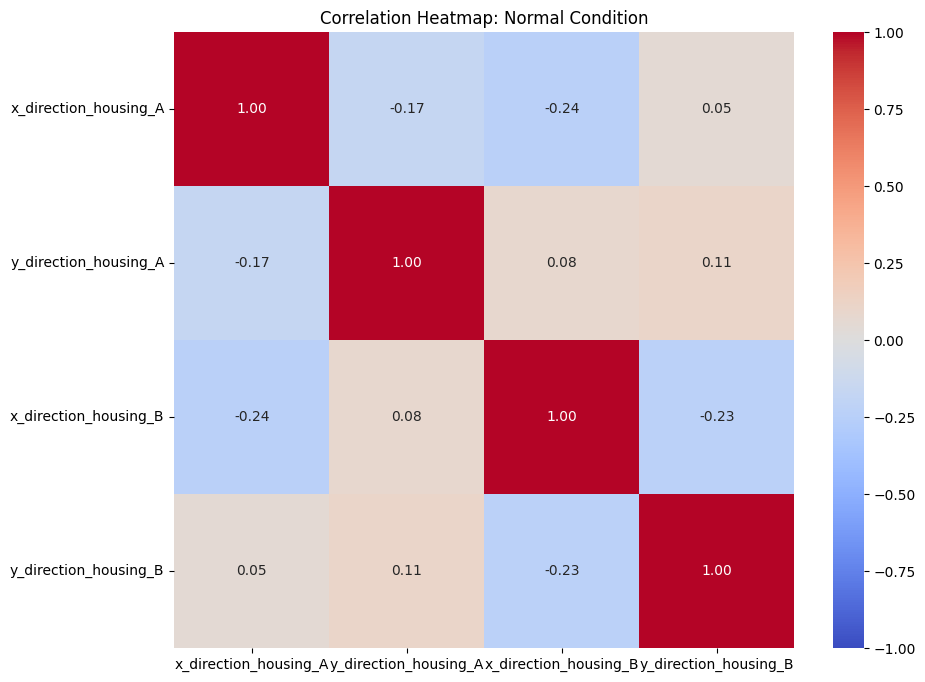

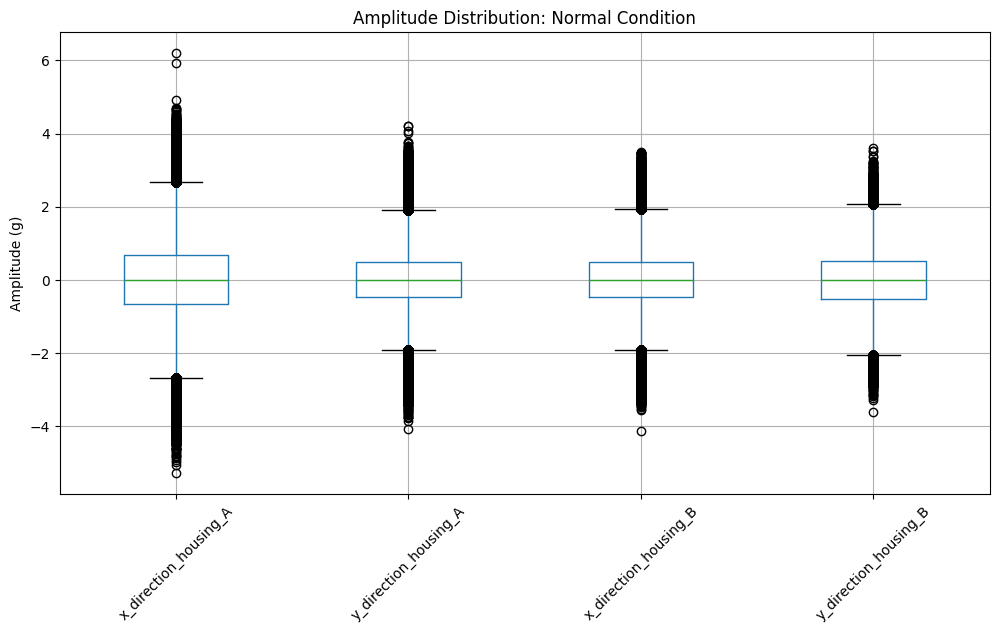

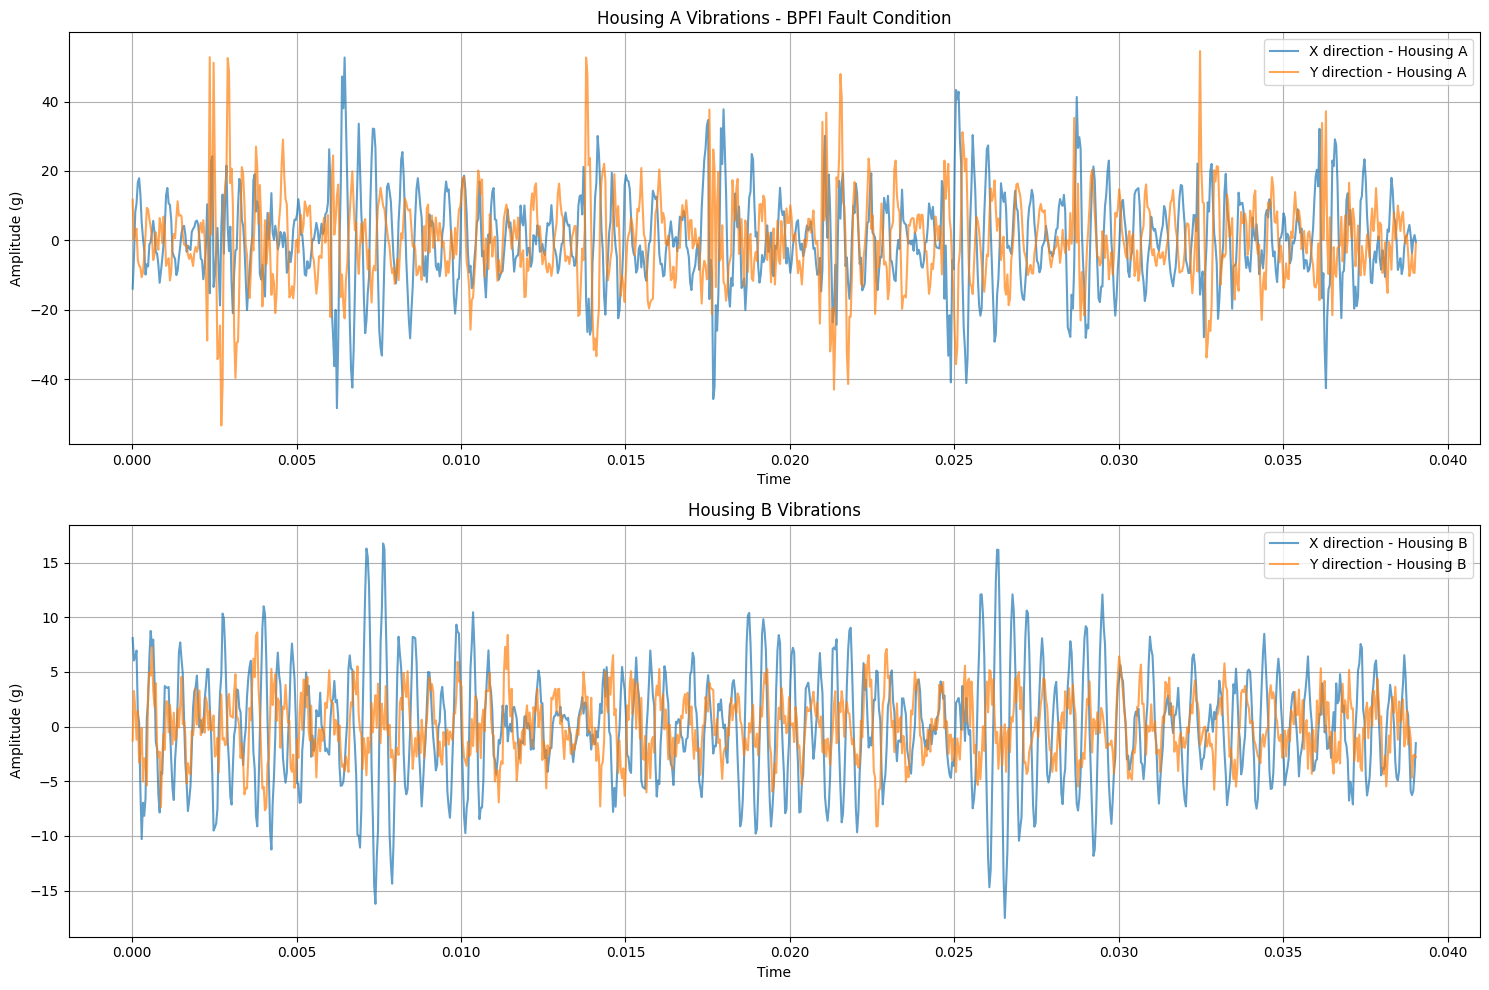

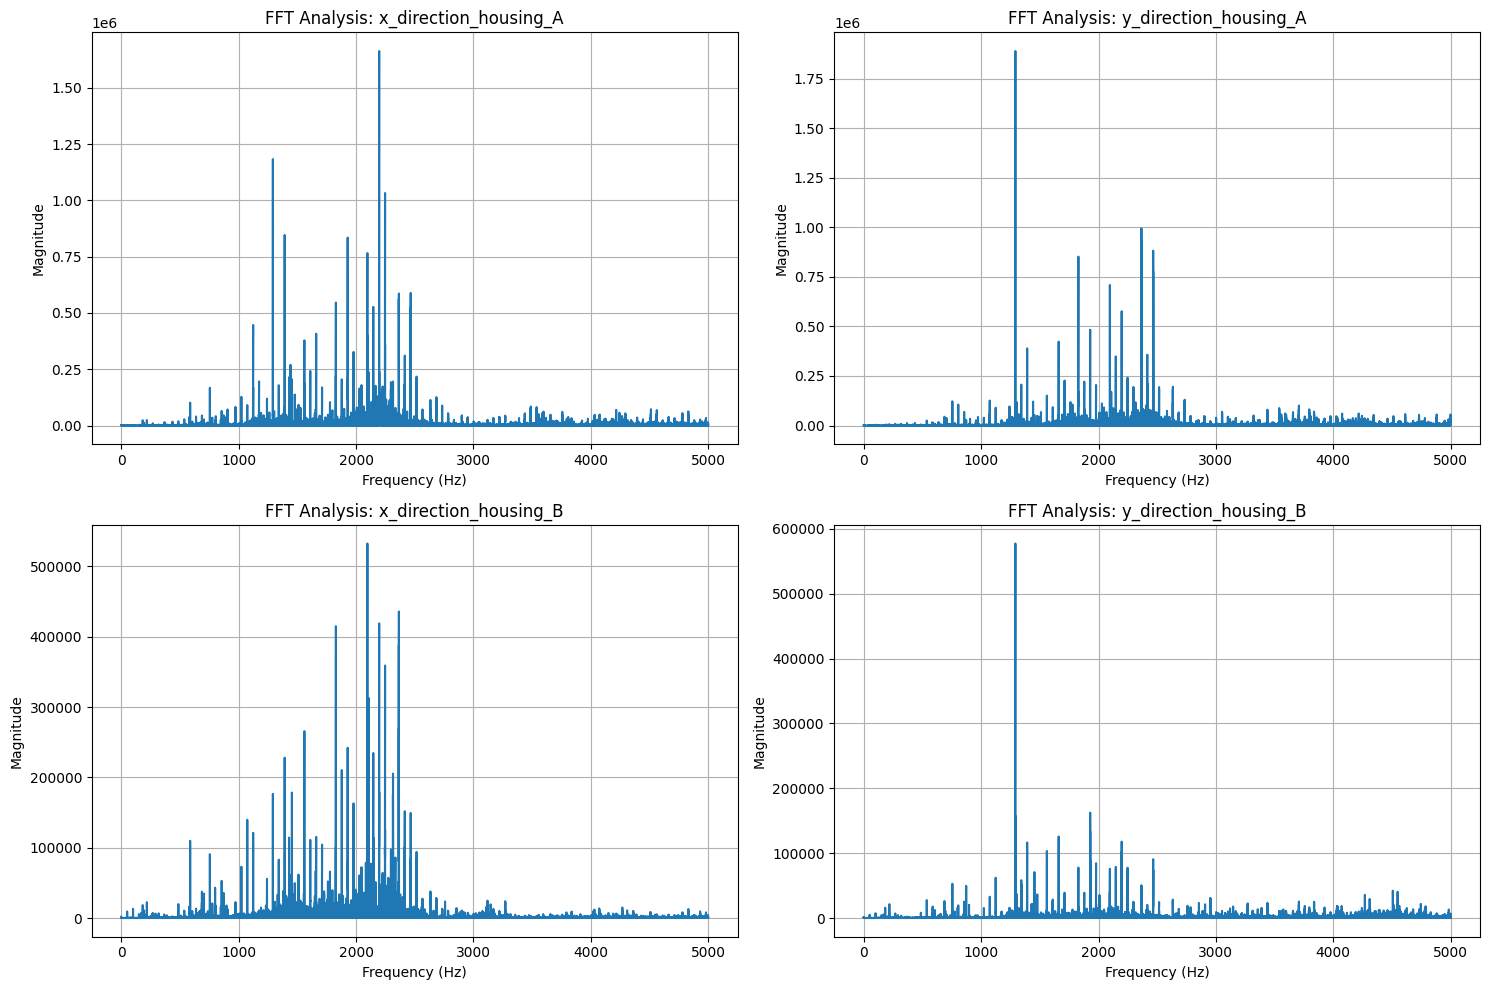


Statistical Summary for BPFI Fault Condition:
       x_direction_housing_A  y_direction_housing_A  x_direction_housing_B  \
count           1.536000e+06           1.536000e+06           1.536000e+06   
mean            3.347130e-04           1.142236e-03           1.182212e-03   
std             1.326247e+01           1.235208e+01           5.209576e+00   
min            -6.710507e+01          -7.980716e+01          -2.189605e+01   
25%            -7.473587e+00          -7.277081e+00          -3.493739e+00   
50%            -3.912212e-01          -1.666494e-01           9.433155e-02   
75%             7.611085e+00           7.016972e+00           3.460699e+00   
max             7.299070e+01           8.586813e+01           2.344809e+01   

       y_direction_housing_B  
count           1.536000e+06  
mean            2.597266e-04  
std             2.763098e+00  
min            -1.230989e+01  
25%            -1.954306e+00  
50%            -2.037109e-02  
75%             1.945079e+00  
ma

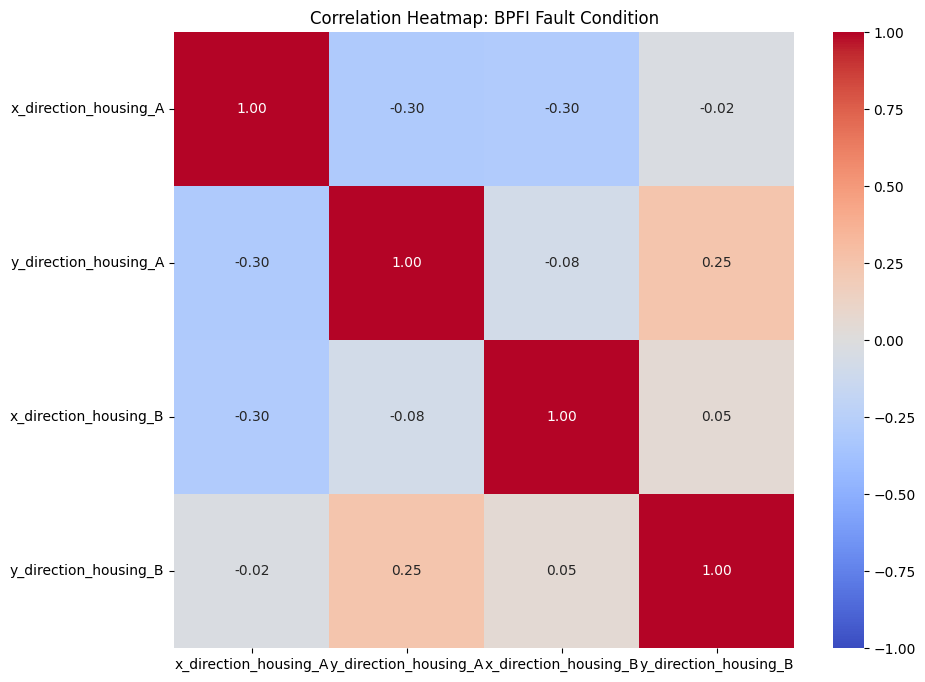

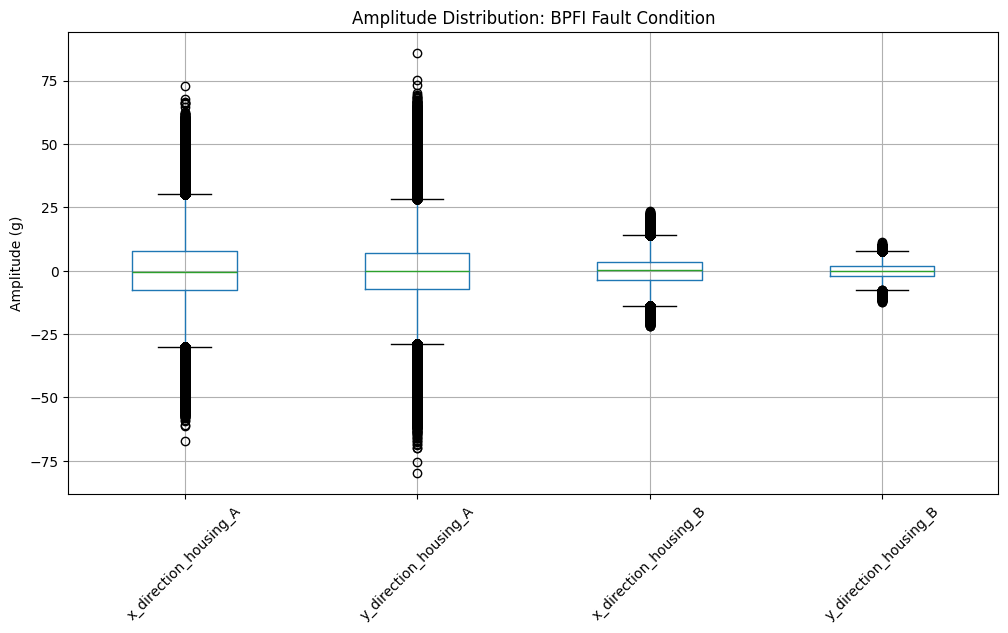

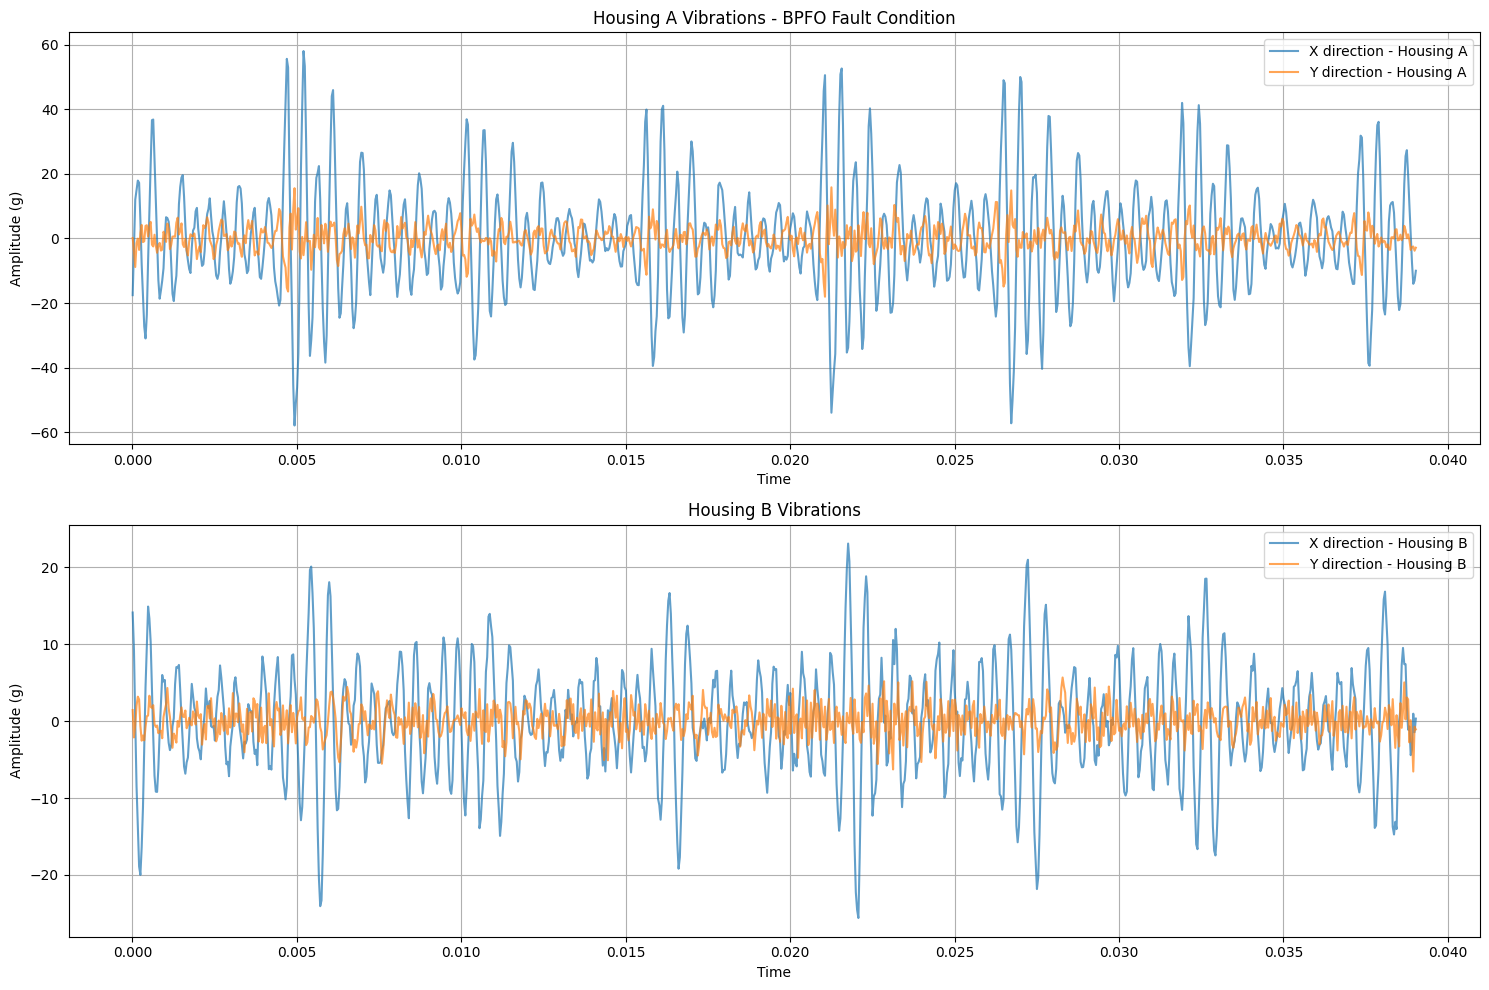

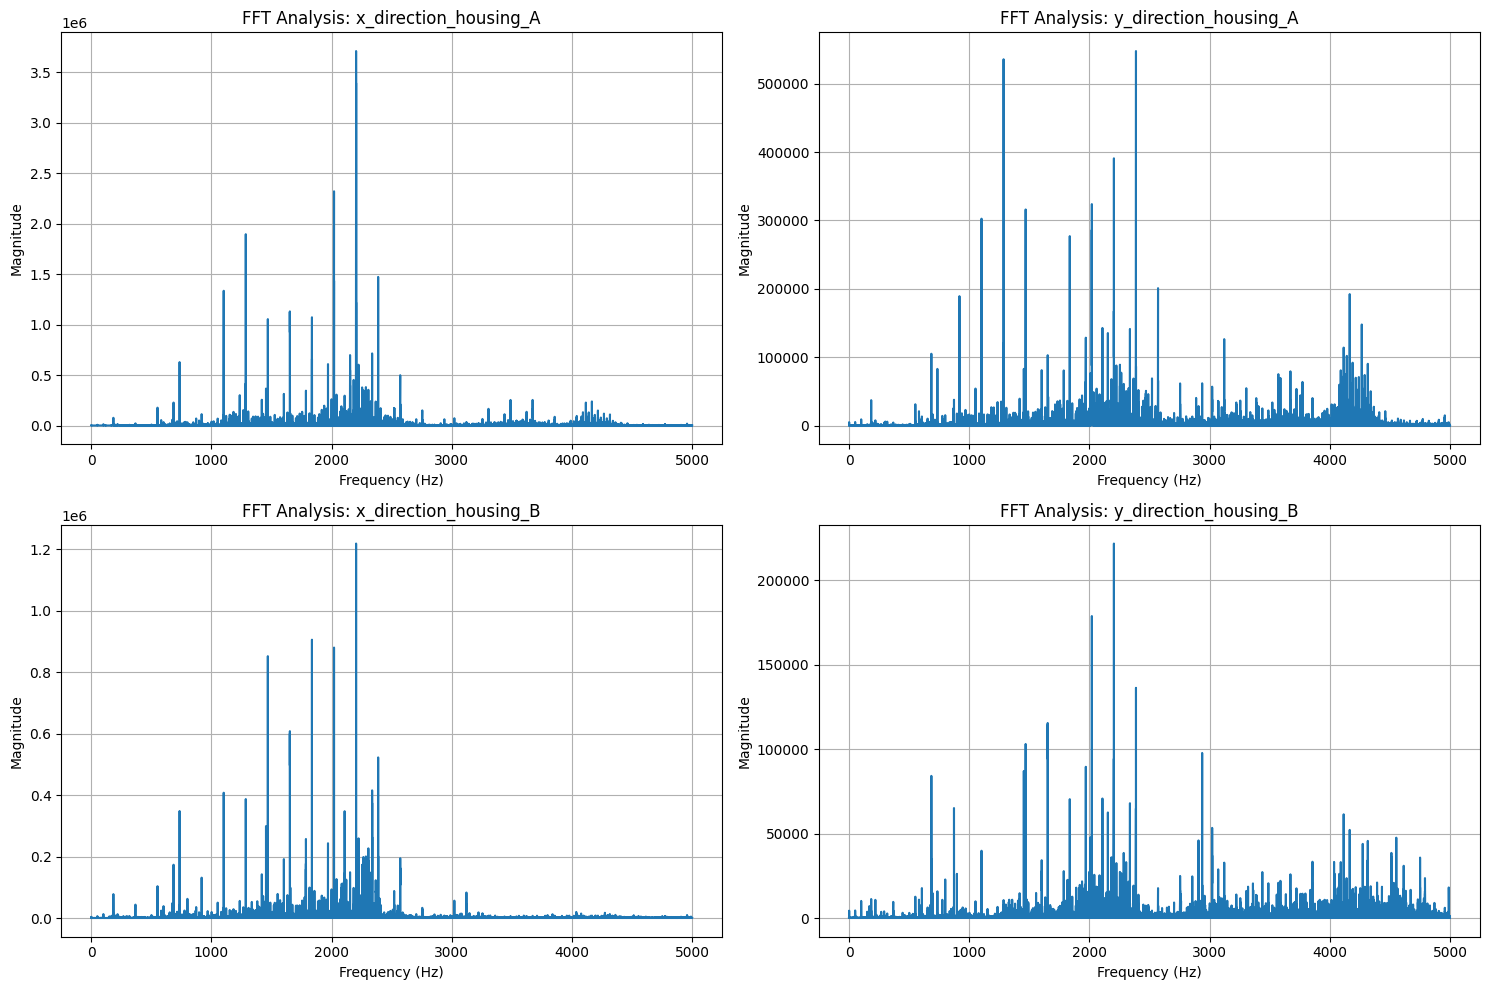


Statistical Summary for BPFO Fault Condition:
       x_direction_housing_A  y_direction_housing_A  x_direction_housing_B  \
count           1.536000e+06           1.536000e+06           1.536000e+06   
mean            2.273134e-04          -2.557806e-04           9.243346e-04   
std             1.713079e+01           4.071874e+00           7.114074e+00   
min            -6.880277e+01          -2.524663e+01          -3.307889e+01   
25%            -9.954687e+00          -2.515227e+00          -4.475960e+00   
50%            -6.348481e-01          -7.223266e-02           2.178724e-02   
75%             9.075160e+00           2.553616e+00           4.580706e+00   
max             7.096993e+01           2.216981e+01           2.862268e+01   

       y_direction_housing_B  
count           1.536000e+06  
mean            1.903350e-04  
std             1.880989e+00  
min            -9.559551e+00  
25%            -1.250425e+00  
50%             1.114418e-02  
75%             1.259892e+00  
ma

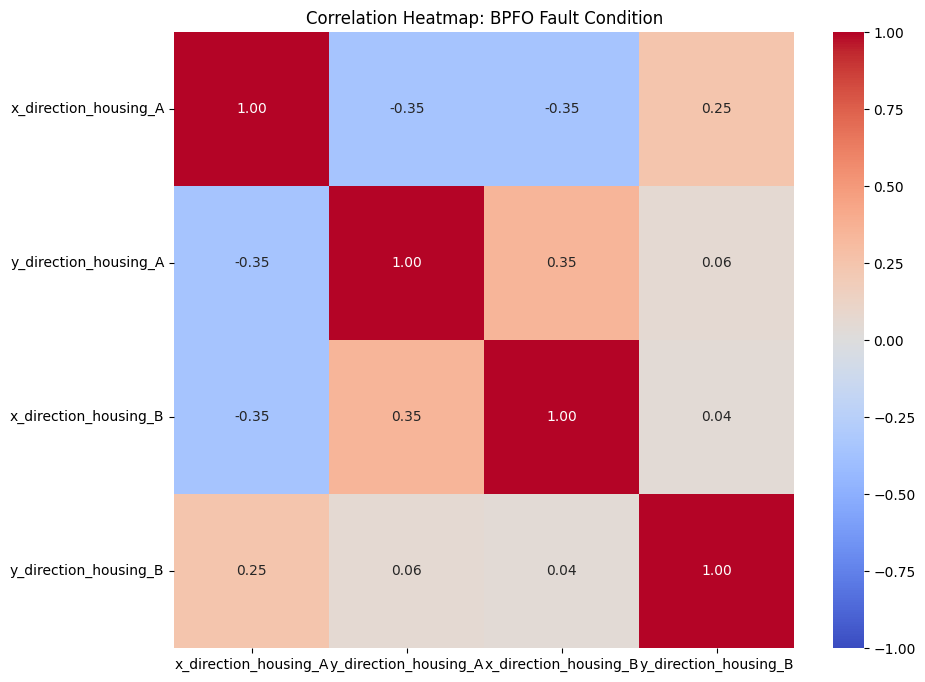

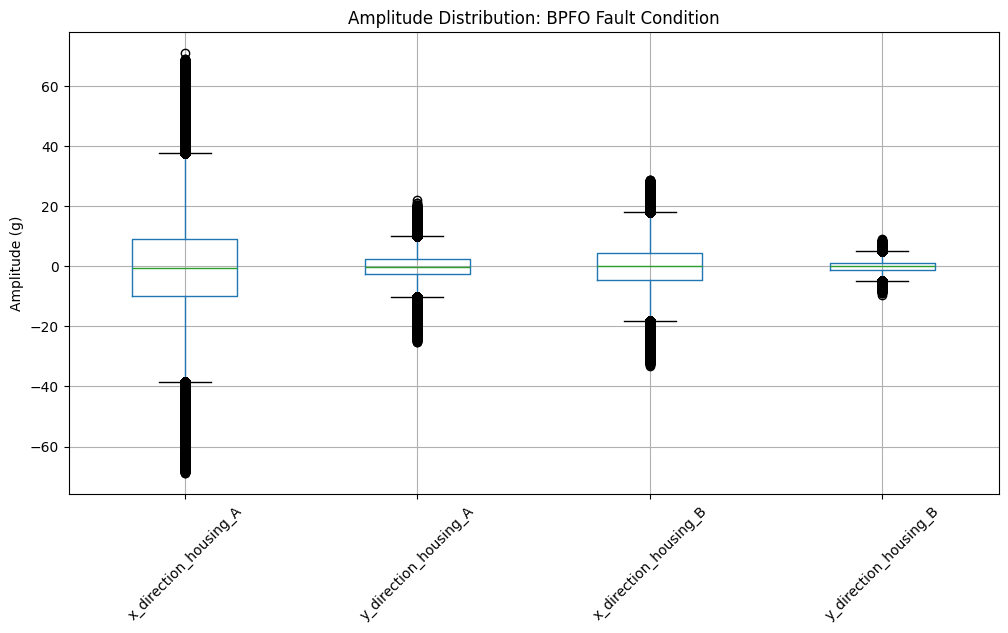

In [3]:
# Path to files
normal_file = "vibration/0Nm_Normal.csv"
bpfi_fault_file = "vibration/0Nm_BPFI_10.csv"
bpfo_fault_file = "vibration/0Nm_BPFO_10.csv"

# Analyze both conditions
load_and_analyze_vibration(normal_file, "Normal Condition")
load_and_analyze_vibration(bpfi_fault_file, "BPFI Fault Condition")
load_and_analyze_vibration(bpfo_fault_file, "BPFO Fault Condition")

## Preparing Data

In [4]:
def load_all_data(data_directory):
    # Initialize an empty list to hold DataFrames
    data_list = []
    
    # Find all CSV files in the directory and subdirectories
    csv_files = glob.glob(os.path.join(data_directory, '*.csv'))
    
    for file in csv_files:
        # Extract the base filename
        base_name = os.path.basename(file)
        
        # Parse filename to extract load and fault type
        try:
            load_fault = base_name.replace('.csv', '').split('_')
            load = load_fault[0].replace('Nm', '')
            fault_type = load_fault[1]
        except IndexError:
            continue
        
        # Map fault types
        label_mapping = {
            'Normal': 'Normal',
            'BPFI': 'Inner_Race_Fault',
            'BPFO': 'Outer_Race_Fault',
        }
        fault_label = label_mapping.get(fault_type, 'Unknown')
        
        # Load the CSV file
        df = pd.read_csv(file)
        df['Fault_Type'] = fault_label
        df['Load_Nm'] = float(load)
        
        # Append to the list
        data_list.append(df)
    
    # Concatenate all DataFrames
    data = pd.concat(data_list, ignore_index=True)
    
    return data

data_directory = "data/vibration/"
combined_data = load_all_data(data_directory)

combined_data.head()

ValueError: No objects to concatenate

In [ ]:
combined_data = combined_data[combined_data['Fault_Type'] != 'Unknown']

In [ ]:
def extract_features(df, window_size=1024, step_size=1024, sampling_rate=25600):
    features_list = []
    
    # Define vibration columns
    vibration_columns = [
        'x_direction_housing_A',
        'y_direction_housing_A',
        'x_direction_housing_B',
        'y_direction_housing_B'
    ]
    
    # Number of samples
    num_samples = len(df)
    
    # Iterate over the data with a sliding window
    for start in range(0, num_samples - window_size + 1, step_size):
        end = start + window_size
        window = df.iloc[start:end]
        feature_dict = {}
        
        # Loop through each vibration channel
        for col in vibration_columns:
            signal = window[col].values
            
            # Time-domain features
            feature_dict[f'{col}_mean'] = np.mean(signal)
            feature_dict[f'{col}_std'] = np.std(signal)
            feature_dict[f'{col}_rms'] = np.sqrt(np.mean(signal**2))
            feature_dict[f'{col}_skewness'] = skew(signal)
            feature_dict[f'{col}_kurtosis'] = kurtosis(signal)
            feature_dict[f'{col}_peak_to_peak'] = np.ptp(signal)
            
            # Frequency-domain features
            fft_result = fft(signal)
            fft_magnitude = np.abs(fft_result)
            freq = fftfreq(len(signal), 1/sampling_rate)
            
            # Only take the positive frequencies
            pos_mask = freq > 0
            fft_magnitude = fft_magnitude[pos_mask]
            freq = freq[pos_mask]
            
            # Dominant Frequency
            feature_dict[f'{col}_dominant_freq'] = freq[np.argmax(fft_magnitude)]
        
        # Label
        feature_dict['Fault_Type'] = window['Fault_Type'].mode()[0]
        feature_dict['Load_Nm'] = window['Load_Nm'].mode()[0]
        
        # Append the feature dictionary to the list
        features_list.append(feature_dict)
    
    # Convert the list of dictionaries to a DataFrame
    features_df = pd.DataFrame(features_list)
    
    return features_df

# Extract features from the combined data
features = extract_features(combined_data)
features.head()

In [ ]:
# Check for missing values
features.isnull().sum()

In [ ]:
# Encode Categorical Labels
le = LabelEncoder()
features['Fault_Type_Encoded'] = le.fit_transform(features['Fault_Type'])

# Save label mapping for future reference
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

In [ ]:
# Feature Scaling
scaler = StandardScaler()

# Features to scale (exclude target variables)
feature_columns = [col for col in features.columns if col not in ['Fault_Type', 'Fault_Type_Encoded']]

# Fit and transform the features
features[feature_columns] = scaler.fit_transform(features[feature_columns])

# Define Features (X) and Target (y)
X = features.drop(['Fault_Type', 'Fault_Type_Encoded'], axis=1)
y = features['Fault_Type_Encoded']

In [ ]:
# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the resampled training data
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()